In [ ]:
import pandas as pd
import numpy as np
import random
random.seed(0)

In [7]:
# 사전 구축한 훈련용 DB 불러오기
df = pd.read_csv('../data/DB(사전학습용).csv', encoding='utf-8')


# 훈련에 사용할 칼럼 결정
col = ['영화명', '장르', '배우', '감독', '제작사', '상영시간', '개봉일', 'Gemini 키워드', '국가', '실관람객 평점', '네티즌 평점', '네이버 관심도(찜)', '누적 관객수', '온라인 판매실적(당월)', '온라인 판매실적(익월)', '온라인 판매실적(익익월)']
df = df[col]
df = df.dropna() # 결측치 있는 행 삭제


# 장르 하나만 선정
df['장르'] = df['장르'].str.split(',', expand=True)[0]

# 배우 한 명만 선정
df['배우'] = df['배우'].str.split(',', expand=True)[0]

# 감독 한 명만 선정
df['감독'] = df['감독'].str.split(',', expand=True)[0]

# 제작사 하나만 선정
df['제작사'] = df['제작사'].str.split(',', expand=True)[0]

# 상영시간 int형으로
df['상영시간'] = df['상영시간'].astype(int)

# 'Gemini 키워드' 컬럼을 쉼표로 분리하여 새로운 칼럼 생성
keywords_split = df['Gemini 키워드'].str.split(',', expand=True)
keywords_split.columns = ['톤', '시대/배경', '주제']
df = pd.concat([df, keywords_split], axis=1)
df = df.drop('Gemini 키워드', axis=1)

# 국가 하나만 선정
df['국가'] = df['국가'].str.split(',', expand=True)[0]

# 관객수 범주화
def convert_audience_to_int(audience_str):
    if isinstance(audience_str, str):
        audience_str = audience_str.replace(',', '')
        if '만' in audience_str:
            try:
                return int(float(audience_str.replace('만', '')) * 10000)
            except ValueError:
                return 0
    return 0

df['관객수_int'] = df['누적 관객수'].apply(convert_audience_to_int)
bins = [0, 100000, 500000, 1000000, 5000000, 10000000, float('inf')]
labels = ['10만 미만', '10만 이상', '50만 이상', '100만 이상', '500만 이상', '1000만 이상']
df['관객수_categorical'] = pd.cut(df['관객수_int'], bins=bins, labels=labels, right=False)

# 개봉일을 연/월로 분리
df['개봉일'] = pd.to_datetime(df['개봉일'], format = '%Y%m%d', errors='coerce')
df['개봉연도'] = df['개봉일'].dt.year
df['개봉월'] = df['개봉일'].dt.month
df['개봉연도'] = df['개봉연도'].fillna(0).astype(int) # 결측값 0으로 채우고 int형으로 자료형 변경
df['개봉월'] = df['개봉월'].fillna(0).astype(int)
df = df.drop('개봉일', axis = 1)

# 온라인 판매실적 컬럼의 쉼표 제거 및 숫자로 변환
sales_cols = ['온라인 판매실적(당월)', '온라인 판매실적(익월)', '온라인 판매실적(익익월)']
for col in sales_cols:
    df[col] = df[col].astype(str).str.replace(',', '', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)


# 매력도 칼럼 생성
df['매력도'] = df['온라인 판매실적(당월)'] + df['온라인 판매실적(익월)'] + df['온라인 판매실적(익익월)']

# 결과 확인
display(df.head())

,영화명,장르,배우,감독,제작사,상영시간,국가,실관람객 평점,네티즌 평점,네이버 관심도(찜),...,온라인 판매실적(익월),온라인 판매실적(익익월),톤,시대/배경,주제,관객수_int,관객수_categorical,개봉연도,개봉월,매력도
0,1947 보스톤,드라마,하정우,강제규,(주)비에이엔터테인먼트,108,한국,7.811,8.85,7052,...,2397,1443,영감을 주는,역사적,성장,1020000,100만 이상,2023,9,7583
1,1980,드라마,강신일,강승용,(주)엣나인필름,99,한국,6.931,6.93,2377,...,12568,6266,우울한,역사적,가족,44000,10만 미만,2024,3,19080
3,3일의 휴가,판타지,김해숙,육상효,글뫼 주식회사,105,한국,8.111,8.51,4149,...,23141,6697,마음이 따뜻해지는,시골,가족,530000,50만 이상,2023,12,89873
4,A MINECRAFT MOVIE 마인크래프트 무비,어드벤처,제이슨 모모아,자레드 헤스,워너브러더스 코리아(주),100,미국,7.541,7.59,2425,...,60879,19222,가볍고 유쾌한,판타지 세계,우정,1350000,100만 이상,2025,4,138132
5,거너,액션,루크 헴스워스,디미트리 로고데티스,주식회사 풍경소리,105,미국,1.601,1.60,22,...,1817,729,긴장감 있는,현대,가족,0,10만 미만,2025,4,5748


# 모델링 

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import accuracy_score

In [12]:
# x, y 데이터로 분할
x = df[['장르', '감독', '제작사','실관람객 평점', '네티즌 평점', '네이버 관심도(찜)', '톤', '시대/배경', '주제', '개봉연도', '개봉월', '관객수_int']]
y = df["매력도"]

# 훈련용, 학습용 데이터셋으로 분할
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 카테고리형 데이터 인코딩
categorical_cols = ['장르', '감독', '제작사', '톤', '시대/배경', '주제']

ord = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
x_train[categorical_cols] = ord.fit_transform(x_train[categorical_cols])
x_test[categorical_cols] = ord.transform(x_test[categorical_cols])



def smape(y_true, y_pred):
   numerator = np.abs(y_pred - y_true)
   denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
   #Avoid division by zero
   return np.mean(numerator / np.maximum(denominator, 1e-8)) * 100

In [13]:
# 각 모델별 성능 비교 (낮을수록 성능 좋음)

# 랜덤 포레스트
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)
smape_value = smape(y_test, y_pred_rf)
print(f"랜덤 포레스트 SMAPE: {smape_value:.2f}%")

# 엑스트라트리
dt = ExtraTreesRegressor(n_estimators=100, random_state=42)
dt.fit(x_train, y_train)
y_pred_dt = dt.predict(x_test)
smape_value = smape(y_test, y_pred_dt)
print(f"엑스트라트리 SMAPE: {smape_value:.2f}%")

# xgboost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(x_train, y_train)
y_pred_xgb = xgb_model.predict(x_test)
smape_value = smape(y_test, y_pred_xgb)
print(f"xgboost SMAPE: {smape_value:.2f}%")


랜덤 포레스트 SMAPE: 86.64%
엑스트라트리 SMAPE: 92.36%
xgboost SMAPE: 110.71%


In [14]:
# 극단값에 가중치 부여
def create_sample_weights(y, extreme_weight=10):
    weights = np.ones(len(y))
    extreme_indices = (y > np.percentile(y, 70)) | (y < np.percentile(y, 30))
    weights[extreme_indices] = extreme_weight
    return weights

sample_weights = create_sample_weights(y_train)

rf_weighted = RandomForestRegressor(n_estimators=200, random_state=42)
rf_weighted.fit(x_train, y_train, sample_weight=sample_weights)
y_pred_weighted_rf = rf_weighted.predict(x_test)
smape_value = smape(y_test, y_pred_weighted_rf)
print(f"가중치가 부여된 랜덤 포레스트 SMAPE: {smape_value:.2f}%")

dt_weighted = ExtraTreesRegressor(n_estimators=200, random_state=42)
dt_weighted.fit(x_train, y_train, sample_weight=sample_weights)
y_pred_weighted_dt = dt_weighted.predict(x_test)
smape_value = smape(y_test, y_pred_weighted_dt)
print(f"가중치가 부여된 엑스트라트리 SMAPE: {smape_value:.2f}%")

xgb_weighted = xgb.XGBRFRegressor(n_estimators=200, random_state=42)
xgb_weighted.fit(x_train, y_train, sample_weight=sample_weights)
y_pred_weighted_xgb = xgb_weighted.predict(x_test)
smape_value = smape(y_test, y_pred_weighted_xgb)
print(f"가중치가 부여된 XGBoost SMAPE: {smape_value:.2f}%")

가중치가 부여된 랜덤 포레스트 SMAPE: 80.86%
가중치가 부여된 엑스트라트리 SMAPE: 97.79%
가중치가 부여된 XGBoost SMAPE: 78.37%


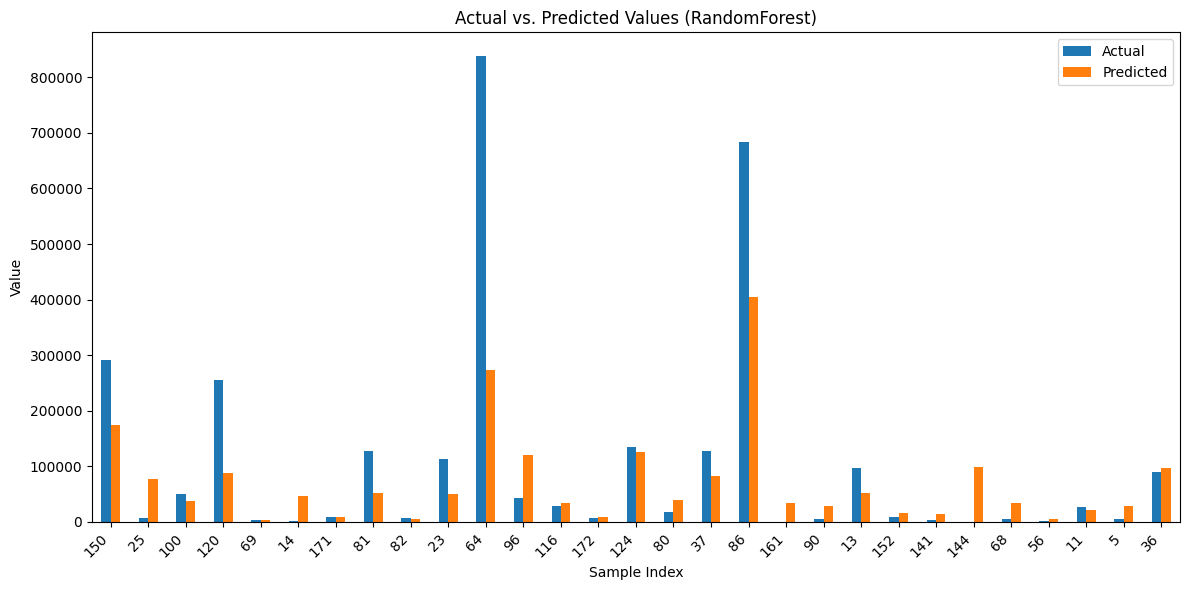

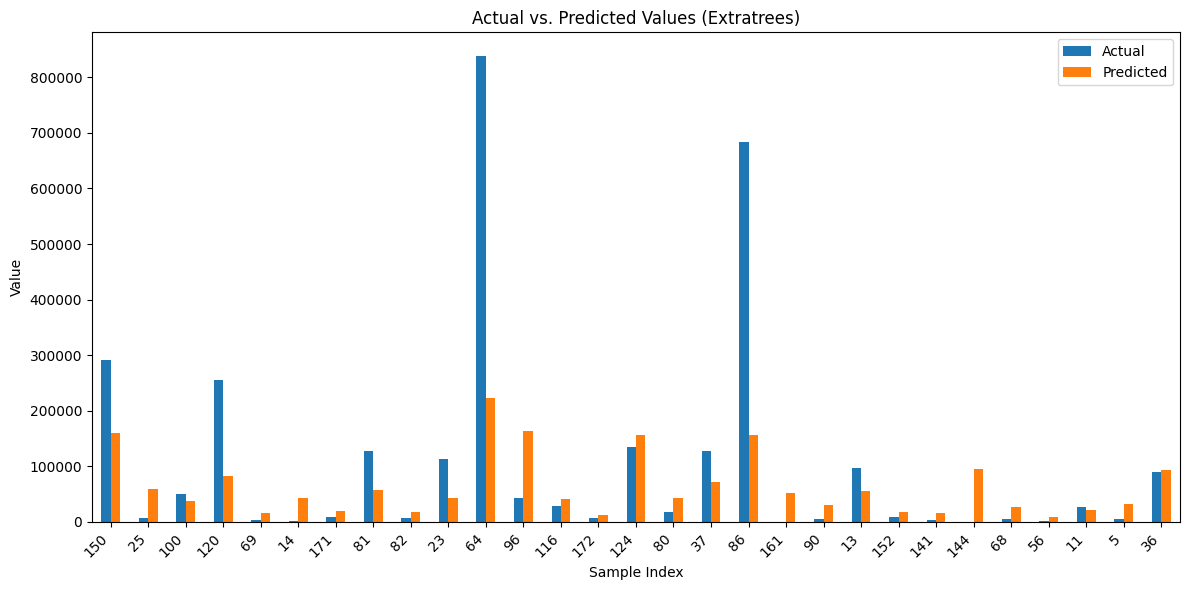

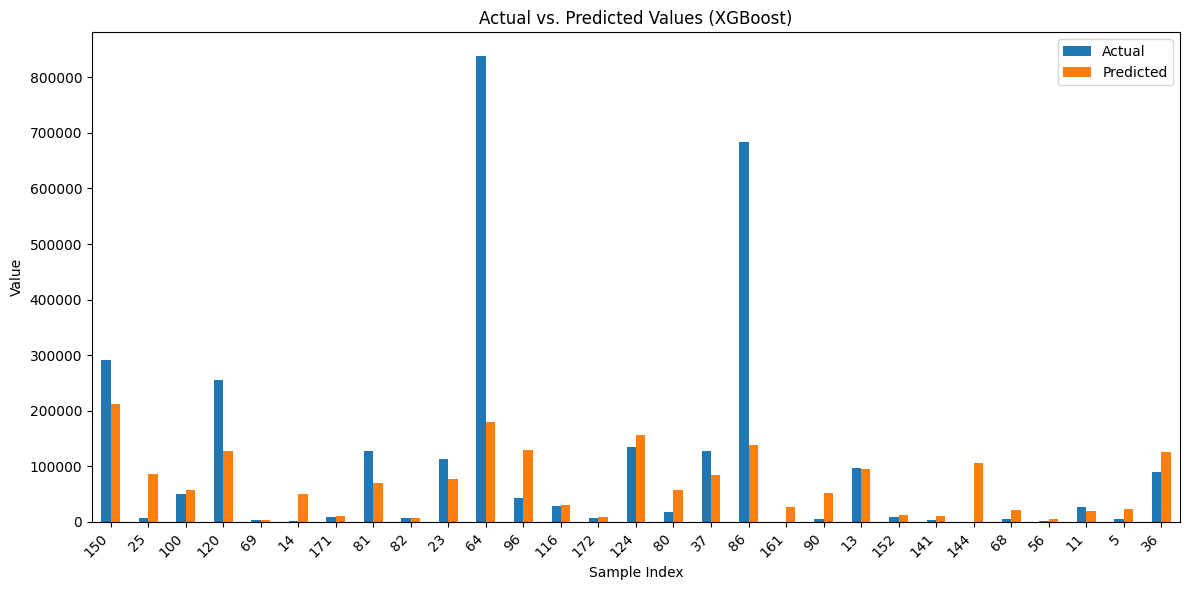

In [15]:
import matplotlib.pyplot as plt

# 예측값과 실제값 시각화
answers_per_model = [y_pred_weighted_rf, y_pred_weighted_dt, y_pred_weighted_xgb]
model_name = ['RandomForest', 'Extratrees', 'XGBoost']

for i, y_pred in enumerate(answers_per_model):
  sample_indices = y_test.index[:]
  sample_y_test = y_test.loc[sample_indices]
  sample_y_pred = y_pred[:]

  plot_df = pd.DataFrame({'Actual': sample_y_test, 'Predicted': sample_y_pred})

  plot_df.plot(kind='bar', figsize=(12, 6))
  plt.xlabel("Sample Index")
  plt.ylabel("Value")
  plt.title(f"Actual vs. Predicted Values ({model_name[i]})")
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

In [16]:
# 훈련 데이터 분류 정확도

y_train_categorical = pd.cut(y_train, bins=bins, labels=labels, right=False)
y_pred_categorical = pd.cut(rf_weighted.predict(x_train), bins=bins, labels=labels, right=False)
comparison_crosstab = pd.crosstab(y_train_categorical, y_pred_categorical, dropna=False)

print("Categorized Actual vs. Predicted Values Comparison:")
display(comparison_crosstab)

accuracy = accuracy_score(y_train_categorical, y_pred_categorical)
print(f"Accuracy Score: {accuracy:.2f}")

Categorized Actual vs. Predicted Values Comparison:


col_0,10만 미만,10만 이상,50만 이상,100만 이상,500만 이상,1000만 이상
매력도,,,,,,
10만 미만,87,4,0,0,0,0
10만 이상,2,20,0,0,0,0
50만 이상,0,0,0,0,0,0
100만 이상,0,0,1,0,0,0
500만 이상,0,0,0,0,0,0
1000만 이상,0,0,0,0,0,0


Accuracy Score: 0.94


In [17]:
# 테스트 데이터 분류 정확도

bins = [0, 50000, 100000, 500000, float('inf')]
labels = ['5만 미만', '5만 이상', '10만 이상', '50만 이상']

y_test_categorical = pd.cut(y_test, bins=bins, labels=labels, right=False)
y_pred_categorical = pd.cut(y_pred_weighted_rf, bins=bins, labels=labels, right=False)
comparison_crosstab = pd.crosstab(y_test_categorical, y_pred_categorical, dropna=False)

print("Categorized Actual vs. Predicted Values Comparison:")
display(comparison_crosstab)

accuracy = accuracy_score(y_test_categorical, y_pred_categorical)
print(f"Accuracy Score: {accuracy:.2f}")

Categorized Actual vs. Predicted Values Comparison:


col_0,5만 미만,5만 이상,10만 이상,50만 이상
매력도,,,,
5만 미만,15,2,1,0
5만 이상,1,2,0,0
10만 이상,0,4,2,0
50만 이상,0,0,2,0


Accuracy Score: 0.66


In [ ]:
# 인코더 및 모델 저장
import joblib

joblib.dump(ord, 'ordinal_encoder.pkl')
joblib.dump(rf_weighted, 'rf_weighted_model.pkl')

['rf_weighted_model.pkl']